In [57]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
def read_spikes_from_disk(path):
    data = np.load(path)

    # compatability with old datasets
    val_filenames = []
    if 'validation_filenames' in data:
        val_filenames = data['validation_filenames']

    return data['train_set'], data['train_labels'], data['train_gunshot_data'], data['validation_set'], data['validation_labels'], data['validation_gunshot_data'], val_filenames, data['test_set'], data['test_labels']

In [59]:
# for now let's take the output from snn/make_dataset.py
# it generates a DWT spectrogram matrix that is normalized to 0-1

training_data, training_labels, _, validation_data, validation_labels, _, _, test_data, test_labels = read_spikes_from_disk('../snn/data/120-dwt.npz')

In [60]:
training_data = torch.tensor(training_data)
training_data = training_data.permute(2, 0, 1) 

# note: delta expects shape (timestep, batch, neuron), also used for input to snn
dm_train_data = spikegen.delta(training_data, threshold=0.0075)

# also do for val set
val_data = torch.tensor(validation_data)
val_data = val_data.permute(2, 0, 1) 

# note: delta expects shape (timestep, batch, neuron), also used for input to snn
dm_val_data = spikegen.delta(val_data, threshold=0.0075)

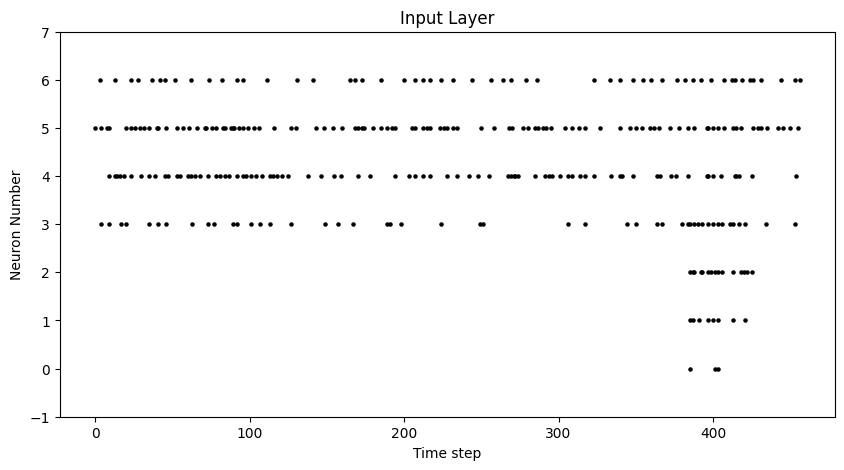

In [61]:
# visualize one sample raster
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(dm_train_data[:, 40, :], ax, s=5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylim(-1,7)
plt.ylabel("Neuron Number")
plt.show()

In [62]:
# Now the network
# Let's try a FFN
# 7x250x250x2
# see https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html
beta = 0.9 # slow decay
num_timesteps = dm_train_data.shape[0]

class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 250)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(250, 250)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(250, 2)
        self.lif3 = snn.Leaky(beta=beta)

    # x will be (timestep x batch x neuron) shape
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spikes = []
        mem_rec = []

        # Note: one timestep is a full pass
        for step in range(num_timesteps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spikes.append(spk3)
            mem_rec.append(mem3)

        return torch.stack(spikes, dim=0), torch.stack(mem_rec, dim=0)

net = SNN().to(device)

In [63]:
# dataset for batches
class SpikesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, index):
        return self.data[:, index, :], self.labels[index]

ds = SpikesDataset(dm_train_data, torch.tensor(training_labels))
loader = DataLoader(ds, batch_size=12, shuffle=True)

In [ ]:
# train
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

ds_test = SpikesDataset(dm_val_data, torch.tensor(validation_labels))
test_loader = DataLoader(ds_test, batch_size=12, shuffle=True)

loss_log = []
for i in range(10):
    print(f'Starting epoch {i}.')
    #with torch.no_grad():
        #net.eval()
        

    net.train()
    for data, labels in loader:
        data = data.to(device)
        labels = labels.to(device)
        
        data = data.permute(1, 0, 2) # permute so we have right shape
        
        spk_rec, mem_rec = net(data)

        # interesting part, we are doing cross entropy loss per timestep here
        loss_val = torch.zeros((1), dtype=torch.float64, device=device)
        for s in range(num_timesteps):
            loss_val += loss(mem_rec[s], labels)
            

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        print(loss_val.item())
        loss_log.append(loss_val.item())

Starting epoch 0.
436.278094291687
352.38512152433395
335.44750452041626
330.28660267591476
331.9217260479927
337.19440829753876
319.23314225673676
321.58466070890427
Starting epoch 1.
320.27762228250504
319.171572804451
311.7026365995407
301.89963883161545
354.6128275990486
320.9567646384239
322.7885023355484
329.78730952739716
Starting epoch 2.
295.65168911218643
341.2515126466751
329.65614783763885
319.1416806578636
308.3727328181267
300.37775403261185
314.21952372789383
324.76153588294983
Starting epoch 3.
315.11431634426117
311.36003851890564
335.0270713567734
306.2348506450653
313.3068300485611
320.5168830752373
307.6228258609772
314.6908708810806
Starting epoch 4.
292.8193829655647
336.25005573034286
289.9637218117714
292.49631118774414
341.4757053256035
365.6167190670967
346.29645973443985
309.0700031518936
Starting epoch 5.
283.99545907974243
334.4771234989166
364.03457540273666
278.974762737751
326.21208238601685


In [ ]:
y = net(dm_train_data[:, 0, :].unsqueeze(1).to(device))
y[1][:, 0, 0]